# 04 Combine files and descriptive statistics
Combine the following files for further analyses and descriptive statistics:
- Manually annotated search queries (ICR + 90% sample)
- Other search query indicators
- Background characteristics

This notebook returns files used for LCA analysis and regression analysis in R, descriptive statistics, as well as a file for robustness check (looser selection criteria: at least two valid search queries).

In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import json
from tqdm import tqdm
from fuzzywuzzy import fuzz

/Users/marieke/Library/Python/3.8/lib/python/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/marieke/Library/Python/3.8/lib/python/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# setting paths
PATH = '/Users/marieke/SearchingForBias'

In [3]:
# search query descriptive variables and terms
df = pd.read_pickle(PATH+'/data/immigration/02_df_sq_vars.pkl')
df.shape

(1994, 46)

In [4]:
#df.head()

In [5]:
# background vars
bg = pd.read_pickle(PATH+'/data/immigration/02_df_bg.pkl')
bg = bg.set_index("ID", drop=True)
bg.shape

(1994, 34)

In [6]:
#bg.head()

In [7]:
df = pd.merge(df, bg, left_index=True, right_index=True, how="left")
df = df.reset_index()

#### Manual coding files

In [8]:
# annotated
# loading a version of the dataset that that manually fixed encoding errors that occured when opening the file in excel.
sample90 = pd.read_excel(PATH+'/data/immigration/manual_coding/sample90_16032021_encoding.xlsx', engine='openpyxl')
sample10 = pd.read_excel(PATH+"/data/immigration/manual_coding/ICB_sample_25022021_MVH_fix.xlsx", engine='openpyxl')

In [9]:
print(sample10.shape, sample90.shape)

(274, 23) (2469, 23)


In [10]:
# combine annotated files
sq = sample90.append(sample10, ignore_index=True, sort=True)

<ipython-input-10-022749dd229f>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sample90.append(sample10, ignore_index=True, sort=True)


In [11]:
# matches (in different word order)
with open(PATH+'/data/immigration/manual_coding/sq_matches_09022021.txt', 'r') as fi:
    matches = json.load(fi)

In [12]:
# add rows to sq for search queries with different word order
df_list=[]
for k, v in matches.items():
    for i in v:
        #print(i)
        tmpdf = sq.loc[sq['search query'] == k].copy()
        tmpdf['search query'] = i
        df_list.append(tmpdf)

In [13]:
# append matches rows to sq tot make sq_total
sq_total = sq.append(pd.concat(df_list), ignore_index=True, sort=True)
sq_total.shape

<ipython-input-13-38b7c9405222>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq_total = sq.append(pd.concat(df_list), ignore_index=True, sort=True)


(2802, 23)

In [14]:
# append columns for each search query match, for each search query column in the main df.

In [15]:
# search query col 1
tmpdf = sq_total.copy()
tmpdf.columns = [c+"_1" for c in tmpdf.columns]
df = pd.merge(df, tmpdf, left_on="MVH_search_im_1_lp", right_on="search query_1", how="left")

In [16]:
# search query col 2
tmpdf = sq_total.copy()
tmpdf.columns = [c+"_2" for c in tmpdf.columns]
df = pd.merge(df, tmpdf, left_on="MVH_search_im_2_lp", right_on="search query_2", how="left")

In [17]:
# search query col 3
tmpdf = sq_total.copy()
tmpdf.columns = [c+"_3" for c in tmpdf.columns]
df = pd.merge(df, tmpdf, left_on="MVH_search_im_3_lp", right_on="search query_3", how="left")

In [18]:
# missing search query --> invalid search query
df.loc[df['search query_1'].isna(), 'VALID_1'] = 0
df.loc[df['search query_2'].isna(), 'VALID_2'] = 0
df.loc[df['search query_3'].isna(), 'VALID_3'] = 0

In [19]:
# how many valid search queries per person.
df['total_valid'] = df[['VALID_1', 'VALID_2', 'VALID_3']].sum(axis=1)
df['total_valid'].value_counts(dropna=False) #,normalize=True)*100

3.0    1607
2.0     164
0.0     132
1.0      91
Name: total_valid, dtype: int64

In [20]:
df['total_valid'].value_counts(dropna=False,normalize=True)*100

3.0    80.591775
2.0     8.224674
0.0     6.619860
1.0     4.563691
Name: total_valid, dtype: float64

In [21]:
### descriptives: age, education, gender (inspect differences before and after sample selection)
# education
round(df.opl_3cat.value_counts(normalize=True, dropna=False)*100)

2    52.0
3    40.0
1     8.0
Name: opl_3cat, dtype: float64

In [22]:
# gender
round(df.base_gender.value_counts(normalize=True, dropna=False)*100)

1    50.0
2    49.0
3     0.0
Name: base_gender, dtype: float64

In [23]:
# mean age
round(df.base_lft.mean())

46

In [24]:
#df.head()

In [25]:
# list of search query indicator columns
sq_cols = [c for c in sq_total.columns if c not in ["Comments", "search query"]]
#sq_cols

In [26]:
# FOR ROBUSTNESS CHECK: loose criteria of >= 2 search queries
df_loose = df.copy()
df_loose = df_loose[((df_loose['total_valid']==2)|(df_loose['total_valid']==3))].copy()
print(df_loose.shape) # number of respondents when at least two valid search queries.
for c in sq_cols:
    df_loose[c] = np.where(df_loose[[f'{c}_1', f'{c}_2', f'{c}_3']].sum(axis=1)>=1, 1, 0)
df_loose.to_csv(PATH+"/data/immigration/robustness_check/df_analysis_2valid.csv",sep='\t', index=False)

(1771, 151)


In [27]:
# only include respondents with three valid search queries.
df = df[((df.VALID_1==1)&(df.VALID_2==1)&(df.VALID_3==1))].copy()
df.shape # new sample size: 1607

(1607, 151)

In [28]:
# combine variables in one 'overall' variable for all three search queries.
# Note. Language in codebook has three categories (0=Dutch, 1=English, 2=Other), but 2 didn't occur.

In [29]:
for c in sq_cols:
    df[c] = np.where(df[[f'{c}_1', f'{c}_2', f'{c}_3']].sum(axis=1)>=1, 1, 0)

In [30]:
### save df for LCA analysis in R
df.to_csv(PATH+"/data/immigration/df_analysis.csv",sep='\t', index=False)

## Descriptive Statistics

In [31]:
cols_lp = ["MVH_search_im_1_lp", "MVH_search_im_2_lp", "MVH_search_im_3_lp"]

In [32]:
# how many unique search queries
all_sq = [item for sublist in df[cols_lp].values.tolist() for item in sublist]
print("total number of valid search queries:", len(all_sq))
tmplst = set(all_sq)
print("unique search queries:", len(tmplst))

total number of valid search queries: 4821
unique search queries: 2342


In [33]:
doubles = []
for i, element in enumerate(tqdm(tmplst)):
    for sq in list(tmplst)[i+1:]:
        if fuzz.token_sort_ratio(element, sq)>=100:
            doubles.append(element)
        else:
            pass

100%|██████████| 2342/2342 [04:08<00:00,  9.44it/s] 


In [34]:
u_sq = [c for c in list(tmplst) if c not in doubles]
print("unique search queries regardless of word order:", len(u_sq))

unique search queries regardless of word order: 2287


In [35]:
# average length of search queries
df["im_len_mean"].describe()

count    1607.000000
mean       18.764987
std         9.733000
min         3.333333
25%        11.666667
50%        16.333333
75%        23.666667
max       116.333333
Name: im_len_mean, dtype: float64

In [36]:
# average number of words per search query.
df['im_nwords_mean'].describe()

count    1607.000000
mean        2.137731
std         1.450193
min         1.000000
25%         1.000000
50%         1.666667
75%         2.666667
max        17.000000
Name: im_nwords_mean, dtype: float64

#### Descriptive statistics for search query indicators

In [37]:
varnames1 = ['SPECIFIC', 'EFFECTIVE', 'QUESTION', 'LANGUAGE']
varnames2=['DEBATE', 'PROBLEMS', 'ADMISSION', 'AZC',
       'HOUSING', 'INTEGRATION', 'CRIME', 'RACISM', 'ECONOMY', 'FINANCIAL_SUPPORT',
       'CULTURE_RELIGION', 'CAUSES', 'POLITICS', 'STATISTICS', 'ORIGIN', 'NEWS']
terms = ['immigrant', 'buitenlander', 'gelukszoeker', 'statushouder', 'allochtoon', 'vluchteling', 'expat', 'asielzoeker']

In [38]:
#tmp1 = pd.DataFrame([(df[varnames1].mean()*100), (df[varnames1].apply(pd.Series.value_counts).T[1])], columns=["Freq (%)", "N"])
tmp1 = pd.DataFrame(round(df[varnames1+varnames2+terms].mean()*100, 1), columns=["Freq (%)"])
tmp2 = pd.DataFrame((df[varnames1+varnames2+terms].apply(pd.Series.value_counts).T[1]))

In [39]:
sq_des = tmp1.join(tmp2)
sq_des.to_latex(PATH+"/report/tables/sq_descriptives.tex")
sq_des

<ipython-input-39-4643e89408d3>:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  sq_des.to_latex(PATH+"/report/tables/sq_descriptives.tex")


,Freq (%),1
SPECIFIC,88.7,1425
EFFECTIVE,98.0,1575
QUESTION,13.8,221
LANGUAGE,1.3,21
DEBATE,3.4,54
PROBLEMS,5.2,84
ADMISSION,27.9,448
AZC,12.3,197
HOUSING,6.1,98
INTEGRATION,14.6,235


In [40]:
### percentages only
tmp1 = pd.DataFrame(round(df[varnames2].mean()*100, 1), columns=["Freq (%)"]).sort_values(by='Freq (%)', ascending=False)
tmp2 = pd.DataFrame(round(df[terms].mean()*100, 1), columns=["Freq (%)"]).sort_values(by='Freq (%)', ascending=False)
sq_des2 = tmp1.append(tmp2)
#sq_des2

<ipython-input-40-3002d543a6b4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq_des2 = tmp1.append(tmp2)


In [41]:
# clean up dataframe
#drop valid,specific,language,question,effectief
names = {'DEBATE':'Debate',
         'PROBLEMS':'Problems',
         'ADMISSION':'Admission',
         'AZC':'Accommodation center',
         'HOUSING':'Housing',
         'INTEGRATION':'Integration',
         'CRIME':'Crime',
         'RACISM':'Racism',
         'ECONOMY':'Economy',
         'FINANCIAL_SUPPORT':'Financial support',
         'CULTURE_RELIGION':'Culture and religion',
         'CAUSES':'Causes',
         'POLITICS':'Politics',
         'STATISTICS':'Statistics',
         'ORIGIN':'Origin',
         'NEWS':'News',
         'immigrant':'Immigrant',
         'buitenlander':'Buitenlander',
         'gelukszoeker':'Gelukszoeker',
         'statushouder':'Statushouder',
         'allochtoon':'Allochtoon',
         'vluchteling':'Vluchteling',
         'expat':'Expat',
         'asielzoeker':'Asielzoeker'
        }
sq_des2 = sq_des2[~sq_des2.index.isin(['SPECIFIC','VALID','EFFECTIVE', 'QUESTION','LANGUAGE'])]
sq_des2['label']=np.where(sq_des2.index.isin(terms), 'terms', 'topics')
sq_des2.index=sq_des2.index.map(names)

In [42]:
# bar graph
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper")
sns.set(font='serif')
sns.set_style("whitegrid")
#sns.set_style("whitegrid", {"font.family":"serif", "font.serif":["Times", "Palatino", "serif"], "xtick.bottom":True})
#sns.set(rc={"xtick.bottom":True, font='serif'})                                                                                                                                                     
#plt.figure(figsize=(15,25))
plt.figure(figsize=(45,75))

<Figure size 3240x5400 with 0 Axes>

<Figure size 3240x5400 with 0 Axes>

In [43]:
from matplotlib import *
from numpy import *

rcParams['mathtext.it'] = 'STIXGeneral:italic'

In [44]:
italics= ["$\it{"+str(e)+"}$" if e in list(names.values())[-8:] else e for e in sq_des2.index]
sq_des2.index = italics

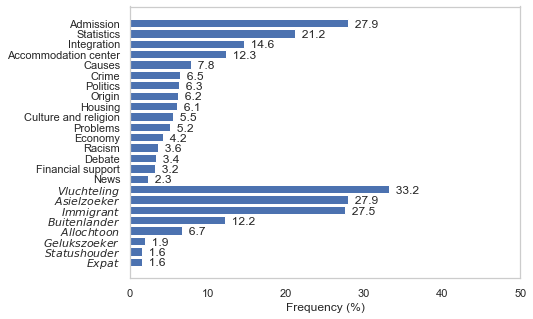

In [45]:
plt.figure(figsize=(7,5))
plt.xlabel('Frequency (%)')
plt.gca().invert_yaxis()
plt.xlim([0, 50])
plt.grid(False)
for index, value in enumerate(sq_des2['Freq (%)']):
    plt.text(value, index, "  "+str(value), va='center_baseline')
plt.barh(sq_des2.index, sq_des2['Freq (%)'])
plt.savefig(PATH+"/report/figures/sq_descriptives.eps", format='eps', dpi=600, bbox_inches='tight', pad_inches = 0)
plt.show()

In [46]:
# how many effective search queries per person.
df['total_effective'] = df[['EFFECTIVE_1', 'EFFECTIVE_2', 'EFFECTIVE_3']].sum(axis=1)
df['total_effective'].value_counts(dropna=False,normalize=True)*100

3.0    70.690728
2.0    20.970753
1.0     6.347231
0.0     1.991288
Name: total_effective, dtype: float64

In [47]:
df['total_effective'].value_counts(dropna=False) #, normalize=True)*100

3.0    1136
2.0     337
1.0     102
0.0      32
Name: total_effective, dtype: int64

In [48]:
len(df[df['EFFECTIVE_1']==0])+len(df[df['EFFECTIVE_2']==0])+len(df[df['EFFECTIVE_3']==0])

599

In [49]:
# how many specific search queries per person.
df['total_specific'] = df[['SPECIFIC_1', 'SPECIFIC_2', 'SPECIFIC_3']].sum(axis=1)
df['total_specific'].value_counts(dropna=False,normalize=True)*100

3.0    32.047293
2.0    31.860610
1.0    24.766646
0.0    11.325451
Name: total_specific, dtype: float64

In [50]:
# how many have zero topics 
df['total_topics'] = df[varnames2].sum(axis=1)
df['total_topics'].value_counts(dropna=False, normalize=True)*100

1    39.079029
2    32.109521
0    17.983821
3    10.392035
4     0.373367
5     0.062228
Name: total_topics, dtype: float64

In [51]:
df['SPECIFIC_1'].value_counts(dropna=False, normalize=True)*100

0.0    54.387057
1.0    45.612943
Name: SPECIFIC_1, dtype: float64

In [52]:
df['SPECIFIC_2'].value_counts(dropna=False, normalize=True)*100

1.0    63.658992
0.0    36.341008
Name: SPECIFIC_2, dtype: float64

In [53]:
df['SPECIFIC_3'].value_counts(dropna=False, normalize=True)*100

1.0    75.35781
0.0    24.64219
Name: SPECIFIC_3, dtype: float64

In [54]:
# English versus Dutch
df['total_english'] = df[['LANGUAGE_1', 'LANGUAGE_2', 'LANGUAGE_3']].sum(axis=1)
df['total_english'].value_counts(dropna=False)

0.0    1586
1.0      12
3.0       6
2.0       3
Name: total_english, dtype: int64

#### Descriptive statistics for independent variables

In [55]:
df['edu_low'] = np.where(df.opl_3cat==1,1,0)
df['edu_mid'] = np.where(df.opl_3cat==2,1,0)
df['edu_high'] = np.where(df.opl_3cat==3,1,0)
df['base_gender2'] = np.where(df.base_gender==1,1,0)

In [56]:
df['edu_mid'].value_counts(dropna=False,normalize=True)

1    0.505289
0    0.494711
Name: edu_mid, dtype: float64

In [57]:
vote = ['VVD','PVV','CDA','D66','GroenLinks','SP','PvdA','ChristenUnie','PvdD',
        '50Plus','SGP','DENK','FvD','Andere_partij']
iv_cat = ['edu_low', 'edu_mid', 'edu_high', 'base_gender2']
iv_con = ['att_im_mean', 'MVH_att_importance_1', 'base_polar', 'base_intpol', 
          'base_lft']

In [58]:
# mean age, gender and education for search query sample
des2 = round(df[iv_con+iv_cat].describe().T[['mean', 'std','min', 'max']],2)
des2

,mean,std,min,max
att_im_mean,4.13,1.51,1.0,7.0
MVH_att_importance_1,3.28,0.98,1.0,5.0
base_polar,5.11,2.30,0.0,10.0
base_intpol,5.22,2.53,0.0,10.0
base_lft,46.26,14.95,18.0,77.0
edu_low,0.07,0.25,0.0,1.0
edu_mid,0.51,0.50,0.0,1.0
edu_high,0.43,0.49,0.0,1.0
base_gender2,0.49,0.50,0.0,1.0


In [59]:
df.shape

(1607, 180)

In [60]:
# how many missing?
df_miss = df[((df.base_polar.isna())|(df.base_intpol.isna())|(df.base_gender==3))]
df_miss

,ID,MVH_search_im_1,MVH_search_im_2,MVH_search_im_3,MVH_search_im_1_lp,MVH_search_im_2_lp,MVH_search_im_3_lp,MVH_search_im_1_lp_ex,MVH_search_im_2_lp_ex,MVH_search_im_3_lp_ex,...,STATISTICS,VALID,total_effective,total_specific,total_topics,total_english,edu_low,edu_mid,edu_high,base_gender2
1,2,asielzoekers,alochtonen,asielzoekerscentrum,asielzoekers,alochtonen,asielzoekerscentrum,asielzoekers,alochtonen,asielzoekerscentrum,...,0,1,3.0,1.0,1,0.0,0,1,0,0
14,15,Immigratie,Discriminatie,Uitzetting,immigratie,discriminatie,uitzetting,immigratie,discriminatie,uitzetting,...,0,1,2.0,2.0,2,0.0,0,1,0,0
19,20,Hoeveel mensen vragen asiel aan per jaar,Waar wonen de minste buitenlanders,Mag iedereen hier komen wonen en werken,hoeveel mensen vragen asiel aan per jaar,waar wonen de minste buitenlanders,mag iedereen hier komen wonen en werken,hoeveel mensen vragen asiel aan per jaar,waar wonen de minste buitenlanders,mag iedereen hier komen wonen en werken,...,1,1,3.0,3.0,4,0.0,1,0,0,1
28,29,immigranten,discussie immigranten,politiek over immigranten,immigranten,discussie immigranten,politiek over immigranten,immigranten,discussie immigranten,politiek over immigranten,...,0,1,3.0,2.0,2,0.0,0,1,0,0
63,64,Assielzoeker,Migranten,Arbeidsmigranten,assielzoeker,migranten,arbeidsmigranten,assielzoeker,migranten,arbeidsmigranten,...,0,1,3.0,1.0,1,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,1910,Pvv,Buitenlanders,Asielzoekers,pvv,buitenlanders,asielzoekers,pvv,buitenlanders,asielzoekers,...,0,1,3.0,1.0,1,0.0,1,0,0,1
1941,1942,allochtonen,emigratie niet Nederlanders,Niet EU-burgers,allochtonen,emigratie niet nederlanders,niet euburgers,allochtonen,emigratie nederlanders,euburgers,...,0,1,3.0,0.0,0,0.0,0,1,0,1
1949,1950,immigranten,buitenlandse mensen,marokkanen,immigranten,buitenlandse mensen,marokkanen,immigranten,buitenlandse mensen,marokkanen,...,0,1,3.0,1.0,0,0.0,0,0,1,0
1969,1970,Nieuwkomers in Nederland,Immigranten,Vluchtelingen in Nederland,nieuwkomers in nederland,immigranten,vluchtelingen in nederland,nieuwkomers in nederland,immigranten,vluchtelingen in nederland,...,0,1,2.0,0.0,0,0.0,0,1,0,1


In [61]:
df_miss.shape

(124, 180)

In [62]:
# exclude respondents with missing values on key IV
#df_reg = df[~((df.Blank==1)|(df.I_do_not_know_yet==1)|(df.I_do_not_want_to_say==1)|
#              (df.base_polar.isna())|(df.base_intpol.isna())|(df.base_gender==3))]
df_reg = df[~((df.base_polar.isna())|(df.base_intpol.isna())|(df.base_gender==3))]
df_reg.shape

(1483, 180)

In [63]:
# cronbach's alpha
pg.cronbach_alpha(df[["MVH_att_im_1", "MVH_att_im_2", "MVH_att_im_3"]])

(0.8374546541623229, array([0.823, 0.851]))

In [64]:
des = round(df_reg[iv_con+iv_cat].describe().T[['mean', 'std','min', 'max']],2)
des.to_latex(PATH+"/report/tables/iv_descriptives.tex")
des

<ipython-input-64-f6d025c4afd0>:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  des.to_latex(PATH+"/report/tables/iv_descriptives.tex")


,mean,std,min,max
att_im_mean,4.17,1.51,1.0,7.0
MVH_att_importance_1,3.31,0.97,1.0,5.0
base_polar,5.11,2.30,0.0,10.0
base_intpol,5.42,2.41,0.0,10.0
base_lft,46.58,14.87,18.0,77.0
edu_low,0.06,0.25,0.0,1.0
edu_mid,0.49,0.50,0.0,1.0
edu_high,0.45,0.50,0.0,1.0
base_gender2,0.51,0.50,0.0,1.0


In [65]:
keep = [c for c in df_reg.columns if not any(z in c for z in (varnames1+varnames2+terms+["MVH_search", 'Comments']))]
df_reg = df_reg[keep].copy()

In [66]:
### save df for regression analysis in R
df_reg.to_csv(PATH+"/data/immigration/df_reg.csv", index=False)